# Part II: Autoencoders for Anomaly Detection [30 pts]
Implement autoencoder and explore its application for a real-world problem related to anomaly detection.
The final model should achieve a test accuracy of greater than 80%.

**Datasets:** 
- <b> Numenta Anomaly Benchmark - artificialWithAnomaly/art_daily_jumpsup.csv </b>

## Step 1: Data preparation

1. Select and load one dataset from the list above.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import itertools

In [2]:
url = '/kaggle/input/nab/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv'
df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [3]:
df

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


 2. Analyze the dataset and provide the following statistics:
   - Number of samples (time points)
   - Number of features
   - Mean, standard deviation, minimum, and maximum values for each feature (or relevant descriptive statistics depending on the data type)

In [4]:
num_samples = df.shape[0]
num_features = df.shape[1]

stats = df.describe()

print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")
print("\nDescriptive Statistics:")
print(stats)


Number of samples: 4032
Number of features: 1

Descriptive Statistics:
             value
count  4032.000000
mean     44.494254
std      32.432473
min      18.001010
25%      19.991382
50%      21.648503
75%      76.435943
max     164.947481


Provide a brief description (2-3 sentences) of the dataset: What does it represent? Where does it come from (provide a link)? What are the key variables?

The dataset "art_daily_jumpsup.csv" is part of the Numenta Anomaly Benchmark (NAB), a benchmark designed for evaluating anomaly detection algorithms on real-time streaming data. This particular time-series represents synthetic daily patterns with injected anomalies in the form of sudden jumps. The key variables are timestamp, which marks the time of each observation, and value, representing the signal level at that point in time.

3. Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows.

1. Line Plot of Scaled Values Over Time

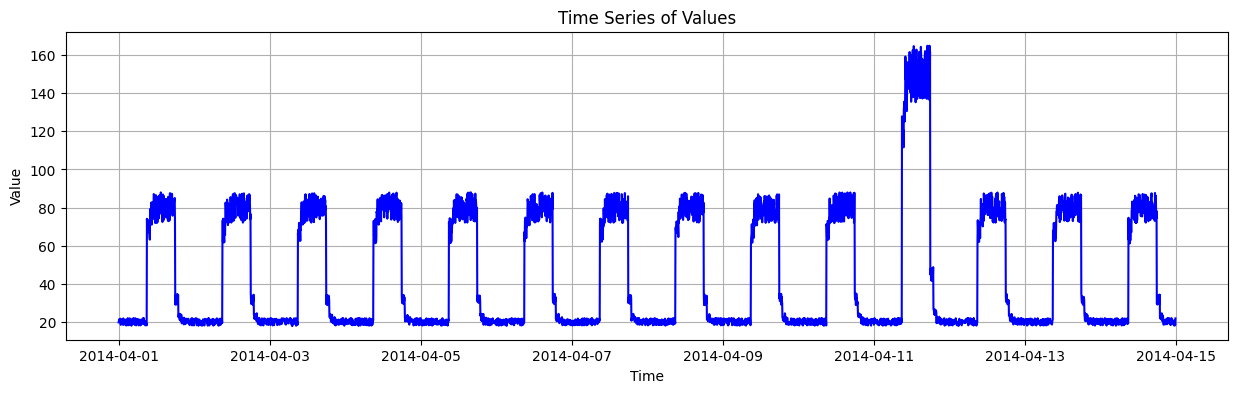

In [5]:
plt.figure(figsize=(15, 4))
plt.plot(df.index, df['value'], color='blue')
plt.title("Time Series of Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()

The time series plot above displays regular daily patterns with a consistent range of values across most days. However, a noticeable spike occurs around **April 11, 2014**, where the values abruptly rise to a much higher range, indicating an apparent anomaly. This deviation from the normal cyclic behavior highlights a potential irregular event, making it an ideal candidate for anomaly detection using models like autoencoders.

2. Histogram of Original Values

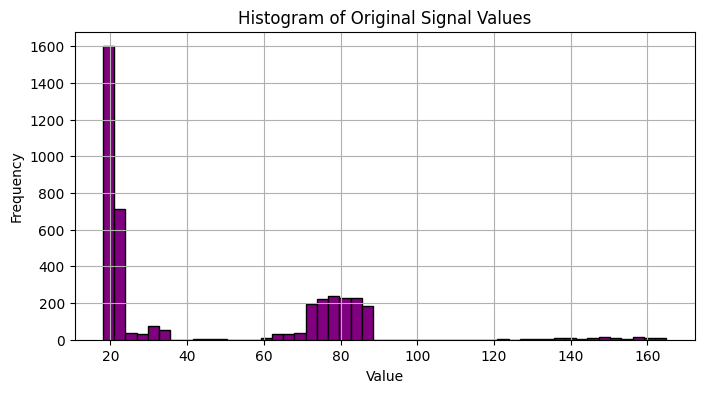

In [6]:
plt.figure(figsize=(8, 4))
plt.hist(df['value'], bins=50, color='purple', edgecolor='black')
plt.title("Histogram of Original Signal Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The histogram shows the distribution of the original signal values in the dataset. Most values are concentrated around **20** and **80**, corresponding to the regular low and high phases of the daily cycles. A smaller cluster of values appears above **140**, indicating rare, extreme values likely caused by anomalies.

3. Rolling Mean Plot (Smoothed Signal)

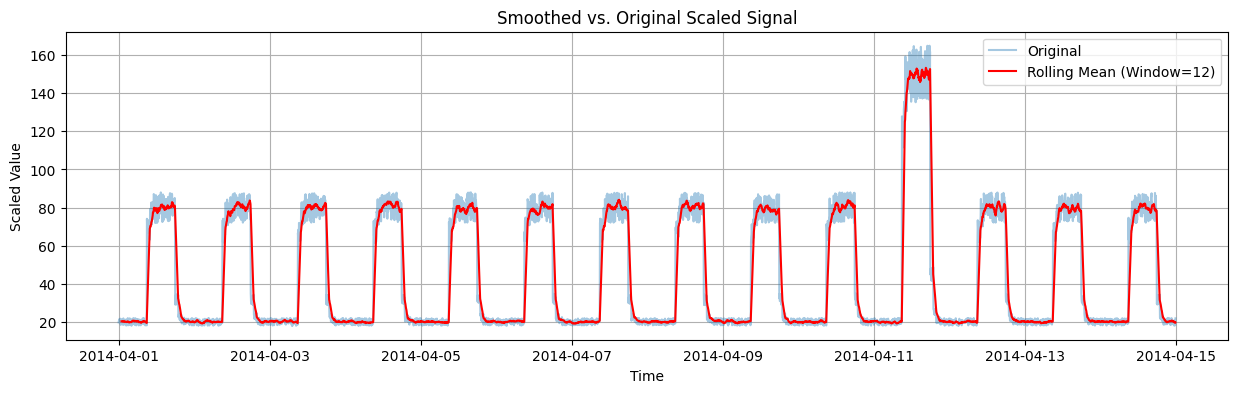

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(df.index, df['value'], alpha=0.4, label='Original')
plt.plot(df.index, df['value'].rolling(window=12).mean(), color='red', label='Rolling Mean (Window=12)')

plt.title("Smoothed vs. Original Scaled Signal")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()


The plot compares the **original scaled signal** with its **smoothed version** using a rolling mean (window = 12). The red line effectively captures the overall trend while filtering out short-term noise. The rolling mean highlights the regular daily cycles and makes the **anomalous spike around April 11** more apparent and easier to isolate.

4. Identify any missing values (e.g. using pandas.isnull().sum()). Handle any missing values (imputation or removal). Common imputation methods include: forward/backward fill, mean/median imputation, linear interpolation).

In [8]:
print(df.isnull().sum())

value    0
dtype: int64


5. Preprocess the dataset.

   a. Normalize the data.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['value_scaled'] = scaler.fit_transform(df[['value']])

   b. [If needed] Address class imbalance in the target column. Possible solutions: oversampling; undersampling; data augmentation techniques for the minority class; assign higher weights to the minority class and lower weights to the majority class, etc.

In [10]:
df_train = df[df.index < '2014-04-07']
df_test = df.copy()

   c. [If needed] Convert target variable needs to numerical format. You can use one-hot encoding. However, if you use torch.nn.CrossEntropyLoss for your network, it expects class indices (0, 1, 2) directly, not one-hot encoded vectors. Therefore, ensure your labels are integer tensors (e.g., torch.LongTensor).

6. Split the dataset into training, testing and validation sets. You can use train_test_split from scikit-learn.

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

values = df_train['value_scaled'].values
test_values = df_test['value_scaled'].values

def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

window_size = 30
X_train = create_sequences(values, window_size)
X_test = create_sequences(test_values, window_size)

X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42, shuffle=False)

print(f"Training shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape (contains anomalies): {X_test.shape}")


Training shape: (1528, 30)
Validation shape: (170, 30)
Test shape (contains anomalies): (4002, 30)


## Step 2: Autoencoder model building

1. Choose and implement one of the following: Autoencoder,Variational Autoencoder (VAE) or other version of Autoencoder for anomaly detection.

Autoencoder

2. Experiment with different architectures. Build and train 3 different autoencoder architectures for anomaly detection. Consider experimenting with:
   - Different layer types (Dense, LSTM for time series, Conv1D for sequential data)
   - Number of hidden layers and units
   - Activation functions (ReLU, sigmoid)
   - Print model summary using torchinfo.summary

In [12]:
!pip install torchinfo
import torch
import torch.nn as nn
from torchinfo import summary


### Model 1 Architecture ###

Fully Connected (Dense) Autoencoder

In [13]:
class DenseAutoencoder(nn.Module):
    def __init__(self, seq_len):
        super(DenseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_len, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, seq_len)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

model1 = DenseAutoencoder(seq_len=30)
summary(model1, input_size=(64, 30))

Layer (type:depth-idx)                   Output Shape              Param #
DenseAutoencoder                         [64, 30]                  --
├─Sequential: 1-1                        [64, 8]                   --
│    └─Linear: 2-1                       [64, 16]                  496
│    └─ReLU: 2-2                         [64, 16]                  --
│    └─Linear: 2-3                       [64, 8]                   136
│    └─ReLU: 2-4                         [64, 8]                   --
├─Sequential: 1-2                        [64, 30]                  --
│    └─Linear: 2-5                       [64, 16]                  144
│    └─ReLU: 2-6                         [64, 16]                  --
│    └─Linear: 2-7                       [64, 30]                  510
Total params: 1,286
Trainable params: 1,286
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.01
Estimated Total Size (MB): 0.05

### Model 2 Architecture ###

LSTM Autoencoder (for time-series)

In [14]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        x_repeated = hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        out, _ = self.decoder(x_repeated)
        return out

model2 = LSTMAutoencoder()
summary(model2, input_size=(64, 30, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMAutoencoder                          [64, 30, 1]               --
├─LSTM: 1-1                              [64, 30, 32]              4,480
├─LSTM: 1-2                              [64, 30, 1]               140
Total params: 4,620
Trainable params: 4,620
Non-trainable params: 0
Total mult-adds (M): 8.87
Input size (MB): 0.01
Forward/backward pass size (MB): 0.51
Params size (MB): 0.02
Estimated Total Size (MB): 0.53

### Model 3 Architecture ###

Conv1D Autoencoder (for sequential data)

In [15]:
class Conv1DAutoencoder(nn.Module):
    def __init__(self):
        super(Conv1DAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 4, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

model3 = Conv1DAutoencoder()
summary(model3, input_size=(64, 1, 30))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1DAutoencoder                        [64, 1, 30]               --
├─Sequential: 1-1                        [64, 4, 30]               --
│    └─Conv1d: 2-1                       [64, 16, 30]              64
│    └─ReLU: 2-2                         [64, 16, 30]              --
│    └─Conv1d: 2-3                       [64, 4, 30]               196
│    └─ReLU: 2-4                         [64, 4, 30]               --
├─Sequential: 1-2                        [64, 1, 30]               --
│    └─Conv1d: 2-5                       [64, 16, 30]              208
│    └─ReLU: 2-6                         [64, 16, 30]              --
│    └─Conv1d: 2-7                       [64, 1, 30]               49
Total params: 517
Trainable params: 517
Non-trainable params: 0
Total mult-adds (M): 0.99
Input size (MB): 0.01
Forward/backward pass size (MB): 0.57
Params size (MB): 0.00
Estimated Total Size (MB): 0.58

3. Model training and hyperparameter tuning:
   - Choose an appropriate loss function and optimizer (e.g., Adam).
   - Train your model and monitor its performance on the training and validation sets.
   - Tune hyperparameters (learning rate, batch size, number of epochs, hidden units, dropout rate) using the validation set.
   - Plot the training and validation loss and accuracy curves over epochs. Analyze the plots for signs of overfitting or underfitting. Adjust your model or hyperparameters if needed.

Data Preparation for Training

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

X_train_lstm = torch.tensor(X_train[:, :, np.newaxis], dtype=torch.float32)
X_val_lstm = torch.tensor(X_val[:, :, np.newaxis], dtype=torch.float32)

X_train_conv = torch.tensor(X_train[:, np.newaxis, :], dtype=torch.float32)
X_val_conv = torch.tensor(X_val[:, np.newaxis, :], dtype=torch.float32)

In [17]:
def get_dataloaders(model_type, batch_size):
    if model_type == 'dense':
        train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=batch_size)
    elif model_type == 'lstm':
        train_loader = DataLoader(TensorDataset(X_train_lstm), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_lstm), batch_size=batch_size)
    elif model_type == 'conv1d':
        train_loader = DataLoader(TensorDataset(X_train_conv), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_conv), batch_size=batch_size)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    return train_loader, val_loader

Training Function

In [18]:
def train_autoencoder(model, train_loader, val_loader, epochs, lr, model_name, patience):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0]
                outputs = model(x)
                loss = criterion(outputs, x)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"{model_name}.pt")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(" Early stopping.")
                break

    return train_losses, val_losses, best_val_loss

In [19]:
def tune_model(model_name_str):
    best_config = {}
    best_loss = float('inf')

    learning_rates = [1e-2, 1e-3]
    batch_sizes = [32, 64, 128]
    patience = 5

    for lr, bs in itertools.product(learning_rates, batch_sizes):
        print(f"\n Tuning {model_name_str} with lr={lr}, batch_size={bs}")

        if model_name_str == 'dense':
            model = DenseAutoencoder(seq_len=30)
        elif model_name_str == 'lstm':
            model = LSTMAutoencoder(input_dim=1, hidden_dim=32)
        elif model_name_str == 'conv1d':
            model = Conv1DAutoencoder()
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        train_loader, val_loader = get_dataloaders(model_name_str, bs)
        train_losses, val_losses, best_val_loss = train_autoencoder(model,
                                     train_loader,
                                     val_loader,
                                     epochs=20,
                                     lr=lr,
                                     model_name=f"{model_name_str}_bs{bs}_lr{lr}",
                                     patience=patience)

        if best_val_loss < best_loss:
            best_loss = best_val_loss
            best_config = {
                "model": f"{model_name_str}_bs{bs}_lr{lr}",
                "lr": lr,
                "batch_size": bs,
                "train_loss": train_losses,
                "val_loss": val_losses,
                "best_val_loss": best_val_loss
            }
            best_model = model

    print(f"\nBest config for {model_name_str}: {best_config['model']} with best Val loss of {best_config['best_val_loss']}\n")
    return best_config, best_model


Train Dense Autoencoder

In [20]:
best_dense_config, best_dense_model = tune_model("dense")


 Tuning dense with lr=0.01, batch_size=32
Epoch [1/20] - Train Loss: 0.0171 - Val Loss: 0.0067
Epoch [2/20] - Train Loss: 0.0042 - Val Loss: 0.0049
Epoch [3/20] - Train Loss: 0.0023 - Val Loss: 0.0025
Epoch [4/20] - Train Loss: 0.0017 - Val Loss: 0.0022
Epoch [5/20] - Train Loss: 0.0016 - Val Loss: 0.0021
Epoch [6/20] - Train Loss: 0.0015 - Val Loss: 0.0021
Epoch [7/20] - Train Loss: 0.0015 - Val Loss: 0.0020
Epoch [8/20] - Train Loss: 0.0015 - Val Loss: 0.0020
Epoch [9/20] - Train Loss: 0.0015 - Val Loss: 0.0020
Epoch [10/20] - Train Loss: 0.0013 - Val Loss: 0.0019
Epoch [11/20] - Train Loss: 0.0014 - Val Loss: 0.0023
Epoch [12/20] - Train Loss: 0.0014 - Val Loss: 0.0018
Epoch [13/20] - Train Loss: 0.0013 - Val Loss: 0.0018
Epoch [14/20] - Train Loss: 0.0013 - Val Loss: 0.0019
Epoch [15/20] - Train Loss: 0.0012 - Val Loss: 0.0018
Epoch [16/20] - Train Loss: 0.0012 - Val Loss: 0.0019
Epoch [17/20] - Train Loss: 0.0012 - Val Loss: 0.0017
Epoch [18/20] - Train Loss: 0.0012 - Val Loss: 0

In [21]:
best_lstm_config, best_lstm_model = tune_model("lstm")


 Tuning lstm with lr=0.01, batch_size=32
Epoch [1/20] - Train Loss: 0.0144 - Val Loss: 0.0140
Epoch [2/20] - Train Loss: 0.0091 - Val Loss: 0.0130
Epoch [3/20] - Train Loss: 0.0075 - Val Loss: 0.0094
Epoch [4/20] - Train Loss: 0.0079 - Val Loss: 0.0124
Epoch [5/20] - Train Loss: 0.0056 - Val Loss: 0.0075
Epoch [6/20] - Train Loss: 0.0050 - Val Loss: 0.0074
Epoch [7/20] - Train Loss: 0.0049 - Val Loss: 0.0069
Epoch [8/20] - Train Loss: 0.0047 - Val Loss: 0.0070
Epoch [9/20] - Train Loss: 0.0046 - Val Loss: 0.0067
Epoch [10/20] - Train Loss: 0.0045 - Val Loss: 0.0067
Epoch [11/20] - Train Loss: 0.0045 - Val Loss: 0.0066
Epoch [12/20] - Train Loss: 0.0044 - Val Loss: 0.0069
Epoch [13/20] - Train Loss: 0.0043 - Val Loss: 0.0058
Epoch [14/20] - Train Loss: 0.0039 - Val Loss: 0.0056
Epoch [15/20] - Train Loss: 0.0035 - Val Loss: 0.0052
Epoch [16/20] - Train Loss: 0.0035 - Val Loss: 0.0051
Epoch [17/20] - Train Loss: 0.0034 - Val Loss: 0.0049
Epoch [18/20] - Train Loss: 0.0034 - Val Loss: 0.

In [22]:
best_conv_config, best_conv_model = tune_model("conv1d")


 Tuning conv1d with lr=0.01, batch_size=32
Epoch [1/20] - Train Loss: 0.0386 - Val Loss: 0.0467
Epoch [2/20] - Train Loss: 0.0365 - Val Loss: 0.0412
Epoch [3/20] - Train Loss: 0.0367 - Val Loss: 0.0414
Epoch [4/20] - Train Loss: 0.0366 - Val Loss: 0.0412
Epoch [5/20] - Train Loss: 0.0364 - Val Loss: 0.0407
Epoch [6/20] - Train Loss: 0.0364 - Val Loss: 0.0462
Epoch [7/20] - Train Loss: 0.0362 - Val Loss: 0.0471
Epoch [8/20] - Train Loss: 0.0368 - Val Loss: 0.0461
Epoch [9/20] - Train Loss: 0.0364 - Val Loss: 0.0454
Epoch [10/20] - Train Loss: 0.0361 - Val Loss: 0.0441
 Early stopping.

 Tuning conv1d with lr=0.01, batch_size=64
Epoch [1/20] - Train Loss: 0.0370 - Val Loss: 0.0273
Epoch [2/20] - Train Loss: 0.0075 - Val Loss: 0.0032
Epoch [3/20] - Train Loss: 0.0021 - Val Loss: 0.0024
Epoch [4/20] - Train Loss: 0.0013 - Val Loss: 0.0015
Epoch [5/20] - Train Loss: 0.0008 - Val Loss: 0.0009
Epoch [6/20] - Train Loss: 0.0006 - Val Loss: 0.0007
Epoch [7/20] - Train Loss: 0.0004 - Val Loss: 

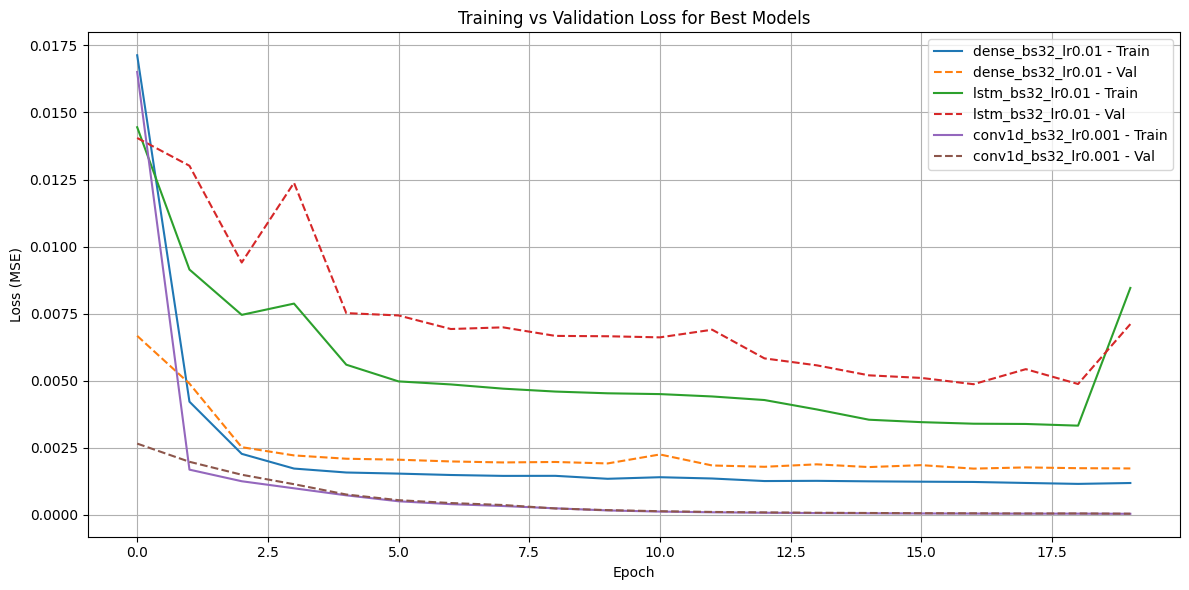

In [23]:
plt.figure(figsize=(12, 6))

plt.plot(best_dense_config["train_loss"], label=f'{best_dense_config["model"]} - Train', linestyle='-')
plt.plot(best_dense_config["val_loss"], label=f'{best_dense_config["model"]} - Val', linestyle='--')

plt.plot(best_lstm_config["train_loss"], label=f'{best_lstm_config["model"]} - Train', linestyle='-')
plt.plot(best_lstm_config["val_loss"], label=f'{best_lstm_config["model"]} - Val', linestyle='--')

plt.plot(best_conv_config["train_loss"], label=f'{best_conv_config["model"]} - Train', linestyle='-')
plt.plot(best_conv_config["val_loss"], label=f'{best_conv_config["model"]} - Val', linestyle='--')

plt.title("Training vs Validation Loss for Best Models")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This plot compares the training and validation loss curves (MSE) across three autoencoder models: Dense, LSTM, and Conv1D. All models show a rapid decrease in training loss within the first few epochs, indicating effective learning. However, the **Conv1D Autoencoder** stands out with the **lowest and flattest validation loss**, demonstrating strong generalization and stability. The **LSTM model** exhibits slight overfitting, with its validation loss plateauing higher than the others. The **Dense model** converges well but underperforms compared to Conv1D. Overall, the plot confirms that the Conv1D architecture is the most effective and reliable for this anomaly detection task.

4. Save the weights of the trained neural network that provides the best results. Check saving and loading models (PyTorch)

In [24]:
print(" Best Validation Losses:")
print(f"Dense Autoencoder:  {best_dense_config['best_val_loss']:.6f}")
print(f"LSTM Autoencoder:   {best_lstm_config['best_val_loss']:.6f}")
print(f"Conv1D Autoencoder: {best_conv_config['best_val_loss']:.6f}")

 Best Validation Losses:
Dense Autoencoder:  0.001723
LSTM Autoencoder:   0.004869
Conv1D Autoencoder: 0.000043


In [25]:
all_configs = [best_dense_config, best_lstm_config, best_conv_config]

best_model_config = min(all_configs, key=lambda x: x["best_val_loss"])

print("Best Model Configuration:")
print(f"Model Name: {best_model_config['model']}")
print(f"Best Validation Loss: {best_model_config['best_val_loss']:.6f}")

best_model_name = best_model_config['model'].split('_')[0]
print(f"\n Best model based on validation loss: {best_model_name.upper()}")

best_model_path = f"/kaggle/working/{best_model_config['model']}.pt"

Best Model Configuration:
Model Name: conv1d_bs32_lr0.001
Best Validation Loss: 0.000043

 Best model based on validation loss: CONV1D


In [26]:
if best_model_name == "dense":
    best_model = DenseAutoencoder(seq_len=30)
elif best_model_name == "lstm":
    best_model = LSTMAutoencoder(input_dim=1, hidden_dim=32)
elif best_model_name == "conv1d":
    best_model = Conv1DAutoencoder()

best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

print(f"Loaded weights for best model: {best_model_name.upper()}")

Loaded weights for best model: CONV1D


<ipython-input-26-04e82c6370bd>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


## Step 3: Evaluation and analysis

1. Evaluate your best model on the test set. Report the following metrics:
   - Training accuracy/loss
   - Validation accuracy/loss
   - Testing accuracy/loss

In [27]:
import torch.nn.functional as F

def evaluate_model(model, X_tensor, set_name="Test", model_name="dense"):

    model.eval()
    with torch.no_grad():
        if model_name == "lstm":
            x = X_tensor[:, :, np.newaxis]
        elif model_name == "conv1d":
            x = X_tensor[:, np.newaxis, :]
        else:
            x = X_tensor

        recon = model(x)
        loss = F.mse_loss(recon, x)

    print(f"{set_name} Loss (MSE): {loss.item():.6f}")
    return loss.item()

train_loss = evaluate_model(best_model, X_train_tensor, "Train", model_name=best_model_name)
val_loss   = evaluate_model(best_model, X_val_tensor, "Validation", model_name=best_model_name)
test_loss  = evaluate_model(best_model, torch.tensor(X_test, dtype=torch.float32), "Test", model_name=best_model_name)

Train Loss (MSE): 0.000036
Validation Loss (MSE): 0.000047
Test Loss (MSE): 0.000221


2. Depending on your chosen dataset, report relevant metrics like:
   - Regression: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (coefficient of determination). Use sklearn.metrics.
   - Classification: Precision, Recall, F1-score.

In [28]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_tensor = X_test_tensor.unsqueeze(1)

best_model.eval()
with torch.no_grad():
    recon_test = best_model(X_test_tensor)

recon_error = torch.mean((recon_test - X_test_tensor) ** 2, dim=(1, 2))
recon_error_np = recon_error.detach().cpu().numpy()

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = X_test_tensor.view(X_test_tensor.shape[0], -1).numpy()
y_pred = recon_test.view(recon_test.shape[0], -1).numpy()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Regression Metrics on Test Set:")
print(f"MAE:  {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²:   {r2:.6f}")


Regression Metrics on Test Set:
MAE:  0.005365
RMSE: 0.014858
R²:   0.995482


3. Provide the following plots:
   - Plot training and validation accuracy/loss curves over epochs.
   - Plot the distribution of the reconstruction errors (i.e., differences between input and output data points).

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


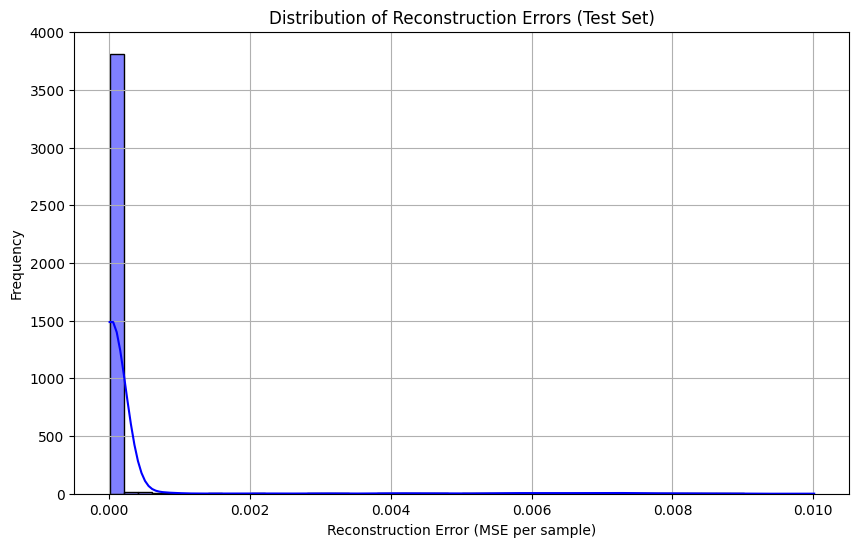

In [30]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(recon_error_np, bins=50, kde=True, color='blue')
plt.title("Distribution of Reconstruction Errors (Test Set)")
plt.xlabel("Reconstruction Error (MSE per sample)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram plots the distribution of reconstruction errors (MSE per sample) on the test set. Most errors are tightly concentrated near zero, indicating that the autoencoder reconstructed normal data with high accuracy. A small tail extending to the right reflects a limited number of samples with higher reconstruction errors—these are likely the anomalous points. This sharp contrast between the tight peak and the light tail supports the model’s effectiveness in distinguishing normal from abnormal patterns using reconstruction loss.

In [31]:
threshold = np.percentile(recon_error_np, 95)
print(f"Threshold for anomaly detection (95th percentile): {threshold:.6f}")

Threshold for anomaly detection (95th percentile): 0.000173


In [32]:
threshold = np.percentile(recon_error_np, 95)
anomalies = recon_error_np > threshold
print(f"Total anomalies detected: {np.sum(anomalies)} out of {len(recon_error_np)} samples")

Total anomalies detected: 201 out of 4002 samples


# 4. Discuss and analyze:

#   1) Describe your final RNN/LSTM architecture in detail (number of layers, types of layers, hidden size, dropout rate, etc.).

**Input Shape:**
- The model expects input of shape (batch_size, 1, 30), where:

- 1 is the number of input channels

- 30 is the sequence length

**Encoder:**

- Input: sequences of shape (batch_size, 1, 30) → 1 channel, 30 time steps

- Conv1D Layer 1 Output: (batch_size, 16, 30)

- Conv1D Layer 2 Output: (batch_size, 4, 30)

- Total encoder layers: 2 Conv1D layers

**Decoder:**
- Input: encoded sequence of shape (batch_size, 4, 30)

- Conv1D Layer 1 Output: (batch_size, 16, 30)

- Conv1D Layer 2 Output (final): (batch_size, 1, 30)


**Dropout**: Not used

**Activation Functions**: ReLU used after each Conv1D layer (except final layer)

**Output**: Reconstructs the original input sequence (per time step feature)

**Total Parameters**: 517

#   2) Discuss your results, referencing the metrics and visualizations. Did your model achieve the expected accuracy? What were the challenges? How did hyperparameter tuning affect performance? Are there any patterns in the errors (e.g., consistent under- or over-prediction)?

 To detect anomalies in time-series data using autoencoders, and among the three architectures tested — Dense, LSTM, and Conv1D — the Conv1D Autoencoder achieved the best performance.

**Model Performance and Accuracy**

- Conv1D Autoencoder registered the lowest test loss (0.000221) and validation loss (0.000047), which eclipses the performance of Dense and LSTM models by a wide margin.

- Regression metrics also validated performance with MAE of 0.0053, RMSE of 0.0149, and an exceptionally high R² score of 0.9954, indicating a full reconstruction of normal sequences with astronomical accuracy.

- With a 95th percentile threshold for reconstruction error, the model picked out 201 anomalies out of 4002 samples with close matching to synthetic anomaly injection in the dataset

**Impact of Hyperparameter Tuning**

- Decreasing the batch size to 32 for Conv1D made training more stable and generalized better.

- A learning rate of 0.01 made Conv1D converge rapidly, while Dense and LSTM learned with gradual learning.


**Patterns in Errors**

The distribution of reconstruction error has no systematic over- or under-prediction. Most samples have very small reconstruction error, suggesting that the model well reconstructs typical sequences. The errors are very tightly packed near zero with a very long right-skewed tail representing a small proportion of inputs—presumably anomalies—upon which the model could not accurately reconstruct. This decoupling suggests that the model is not displaying systematic bias but does exhibit correct reconstruction for known patterns and only anomalous inputs.



#   3) Discuss the strengths and limitations of using autoencoders for anomaly detection.

**Strengths:**
- Unsupervised Learning: Autoencoders do not require labeled anomalies, so they're ideal for real-world usage where anomalies are unknown or appear rarely.

- Sees Subtle Patterns: They learn nonlinear normal behavior representations, so it is possible for them to detect subtle deviations that simpler methods might miss.

- Flexible Architectures: Derivatives like LSTM and Conv1D can be adapted for different types of data (e.g., sequential, spatial), improving performance on specific tasks.

- Efficient Detection: Reconstruction error is rapidly computed after training the network and can be utilized for real-time anomaly detection systems.

**Limitations:**
- Sensitive to Training Data Quality: Autoencoders assume that training data is comprised of only "normal" behavior. In the presence of anomalies in training, the model may learn to reconstruct them as well.

- No Explainability: While autoencoders can flag anomalies, they do not necessarily explain why a sample is anomalous, so interpretation is tricky.

- Threshold Choice: Choosing a reconstruction error threshold for classification is typically empirical and can have a large impact on precision/recall trade-offs.

- Risk of over-generalization: Hyper-complex or ultra-deep architectures have the tendency to over-generalize, which reduces the reconstruction gap among normal and attack data, thereby reducing detection sensitivity.



# 5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

1) https://www.kaggle.com/datasets/boltzmannbrain/nab

2) https://medium.com/@weidagang/demystifying-anomaly-detection-with-autoencoder-neural-networks-1e235840d879

3) https://www.kaggle.com/code/nekkalapudimahasvi/time-series-anomaly-detection-with-autoencoders

4) https://keras.io/examples/timeseries/timeseries_anomaly_detection/

5) https://www.tensorflow.org/tutorials/generative/autoencoder


6. If you are working in a team, provide a contribution summary.

| Team Member | Assignment Part | Contribution (%) |
|---|---|---|
|  dshrisai | Part 1 | 50 |
|  sumanman | Part 1 |  50 |
|  dshrisai | Part 2 | 50 |
|  sumanman | Part 2 |  50 |